# Stage II

# Task1

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv(r"newdata.csv")

features = ["popularity", "duration_ms", "genre"]

le = LabelEncoder()
df["genre_encoded"] = le.fit_transform(df["genre"])

def descriptive_stats(series):
    s = series.dropna()
    return {
        "Count": int(s.shape[0]),
        "Mean": s.mean(),
        "Median": s.median(),
        "Variance": s.var(ddof=1),                
        "Std Dev": s.std(ddof=1),                 
        "Skewness": skew(s, bias=False),
        "Excess Kurtosis": kurtosis(s, fisher=True, bias=False),
        "Min": s.min(),
        "Max": s.max()
    }

stats = {
    "popularity": descriptive_stats(df["popularity"]),
    "duration_ms": descriptive_stats(df["duration_ms"]),
    "genre_encoded": descriptive_stats(df["genre_encoded"])  
}

# Display main stats table
stats_df = pd.DataFrame(stats)
print("\n=== Descriptive Statistics ===")
print(stats_df)

# Helpful: duration in minutes 
if "duration_ms" in stats_df.columns:
    mean_ms = stats_df.loc["Mean", "duration_ms"]
    median_ms = stats_df.loc["Median", "duration_ms"]
    print(f"\nDuration (Mean): {mean_ms:.2f} ms  (~{mean_ms/60000.0:.2f} minutes)")
    print(f"Duration (Median): {median_ms:.2f} ms (~{median_ms/60000.0:.2f} minutes)")

features_map = {
    'duration': 'duration_ms',
    'popularity': 'popularity',
    'genre_encoded': 'genre_encoded'  
}





=== Descriptive Statistics ===
                    popularity   duration_ms  genre_encoded
Count            231949.000000  2.319490e+05  231949.000000
Mean                 41.199169  2.318874e+05      13.630699
Median               43.000000  2.202930e+05      14.000000
Variance            329.676005  8.092881e+09      56.113082
Std Dev              18.156982  8.996044e+04       7.490867
Skewness             -0.337700  1.696823e+00      -0.019501
Excess Kurtosis      -0.396791  6.601105e+00      -1.187282
Min                   0.000000  3.001300e+04       0.000000
Max                 100.000000  8.999330e+05      26.000000

Duration (Mean): 231887.36 ms  (~3.86 minutes)
Duration (Median): 220293.00 ms (~3.67 minutes)


In [3]:
import pandas.api.types as ptypes

def detect_feature_type(series, df=None):
    name = series.name

    # 1) Direct categorical types
    if ptypes.is_bool_dtype(series):
        return "Categorical (binary)"
    if ptypes.is_object_dtype(series) or ptypes.is_categorical_dtype(series):
        return "Categorical"

    # 2) Encoded-categorical heuristic: column ends with '_encoded' and a raw base column exists & is categorical
    if name.endswith("_encoded"):
        base = name[:-8]
        if df is not None and base in df.columns and (ptypes.is_object_dtype(df[base]) or ptypes.is_categorical_dtype(df[base])):
            return "Categorical (encoded as integers)"

    # 3) Numeric split: discrete vs continuous
    if ptypes.is_numeric_dtype(series):
        s = series.dropna()
        unique_vals = s.nunique()
        smin, smax = (s.min(), s.max()) if not s.empty else (None, None)

        if ptypes.is_integer_dtype(series) and smin is not None and smax is not None and 0 <= smin and smax <= 100:
            return "Discrete"

        if ptypes.is_integer_dtype(series) and unique_vals <= 100:
            return "Discrete"

        return "Continuous"

    return "Unknown"

print("\n=== Feature Types ===")
for feature, col_name in features_map.items():
    if col_name in df.columns:
        ftype = detect_feature_type(df[col_name], df)  
        print(f"{feature}: {ftype}")
    else:
        print(f"{feature}: Column not found in dataset")



=== Feature Types ===
duration: Continuous
popularity: Discrete
genre_encoded: Categorical (encoded as integers)


/var/folders/kz/8twlzh4540d3b82ybcqd940c0000gn/T/ipykernel_72418/2111805813.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if ptypes.is_object_dtype(series) or ptypes.is_categorical_dtype(series):


## **Findings**

### **Popularity**
- **Mean:** 41.20 **Median:** 43.00 **Variance:** ≈ 329.68  
- **Skewness:** −0.34 → slightly **left-skewed**, indicating there are a few very low-popularity tracks but most songs cluster around mid-range popularity.  
- **Excess Kurtosis:** −0.40 → **light-tailed**, close to a normal distribution (no extreme outliers).  
- **Interpretation:** Popularity values (0–100) are integer counts representing rating levels; hence the feature is **numerical → discrete**.

---

### **Duration (ms)**
- **Mean:** 231,887 ms **Median:** 220,293 ms **Variance:** ≈ 8.09 × 10⁹  
- **Skewness:** +1.70 → **right-skewed**, meaning some songs are much longer (e.g., live versions or extended mixes).  
- **Excess Kurtosis:** +6.60 → **heavy-tailed**; the dataset contains several unusually long tracks far from the mean.  
- **Interpretation:** Duration is measured in milliseconds and can take many possible values along a continuous scale; hence **numerical → continuous**.

---

### **Genre (encoded)**
- **Mean:** 13.63 **Median:** 14.00 **Variance:** 56.11  
- These numerical summaries come from label encoding and have **no real statistical meaning**, since the codes are arbitrary.  
- **Interpretation:** Genre is a **categorical** variable (text labels like *Pop*, *Rock*, *Jazz*, etc.) that was **encoded as integers** only for computational convenience. The statistics merely reflect the frequency balance of categories, not any inherent numeric property.

---

### **Feature-Type Summary**

| **Feature**      | **Type**                               | **Explanation** |
|------------------:|-----------------------------------------|------------------|
| **duration**      | Continuous (numerical)                 | Measured in milliseconds (`duration_ms`); conceptually continuous over time. |
| **popularity**    | Discrete (numerical)                   | Integer scale 0–100 representing countable popularity levels. |
| **genre_encoded** | Categorical (encoded as integers)      | Encoded version of text-based genres; numeric codes lack quantitative meaning. |


# Task 2

### **Task 2(a): Selection of Feature and Theoretical Distribution**

For this task, the chosen feature is **`duration_ms`**, which represents the duration of each song in milliseconds.

This feature is **numerical and continuous**, as it measures time on a continuous scale and can take a wide range of values. Based on the descriptive statistics from Task 1, the feature exhibits the following characteristics:

- **Mean:** 231,887 ms (~3.86 minutes)  
- **Median:** 220,293 ms (~3.67 minutes)  
- **Skewness:** +1.70 (strong right-skew)  
- **Excess Kurtosis:** +6.60 (heavy-tailed)

These values indicate that while most songs have a duration of about 3-4 minutes, a small number of songs are much longer (such as live versions or extended remixes).  
This pattern - a concentration of shorter values with a long positive tail - is typical of data that follows a **Log-Normal distribution**.

A **Log-Normal distribution** is appropriate when:
- The data are strictly **positive** (no negative durations possible).  
- The distribution is **right-skewed** rather than symmetric.  
- Taking the logarithm of the variable tends to produce an approximately normal distribution.

Therefore, the theoretical distribution proposed for the `duration_ms` feature is the **Log-Normal distribution**.  
It effectively models the natural variation in song lengths, capturing the fact that durations cannot be negative, are clustered around a typical length, and occasionally extend into a long tail of unusually lengthy tracks.


# --- Task 2(b): Distribution Fitting and Visualization ---

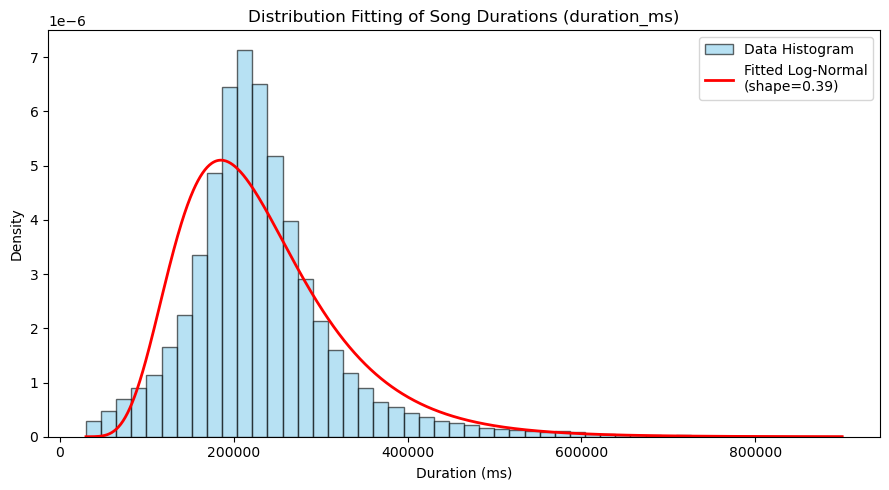

KS Statistic: 0.0868
p-value: 0.0000
Reject H0 → The data does not perfectly follow a Log-Normal distribution, but it may still approximate it visually.


In [8]:
# --- Task 2(b): Distribution Fitting and Visualization ---

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, kstest

# Select the feature
x = df["duration_ms"].dropna()

# --- Fit a Log-Normal distribution ---
# floc=0 fixes the location to zero since durations can't be negative
shape, loc, scale = lognorm.fit(x, floc=0)

# --- Generate smooth curve for the fitted PDF ---
x_min, x_max = x.min(), x.max()
x_vals = np.linspace(x_min, x_max, 1000)
pdf_vals = lognorm.pdf(x_vals, shape, loc, scale)

# --- Plot histogram + fitted curve ---
plt.figure(figsize=(9, 5))
plt.hist(x, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label="Data Histogram")
plt.plot(x_vals, pdf_vals, 'r-', lw=2, label=f"Fitted Log-Normal\n(shape={shape:.2f})")
plt.title("Distribution Fitting of Song Durations (duration_ms)")
plt.xlabel("Duration (ms)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

ks_stat, ks_pvalue = kstest(x, 'lognorm', args=(shape, loc, scale))
print(f"KS Statistic: {ks_stat:.4f}")
print(f"p-value: {ks_pvalue:.4f}")

if ks_pvalue > 0.05:
    print("Fail to reject H0 → The data reasonably fits a Log-Normal distribution.")
else:
    print("Reject H0 → The data does not perfectly follow a Log-Normal distribution, but it may still approximate it visually.")


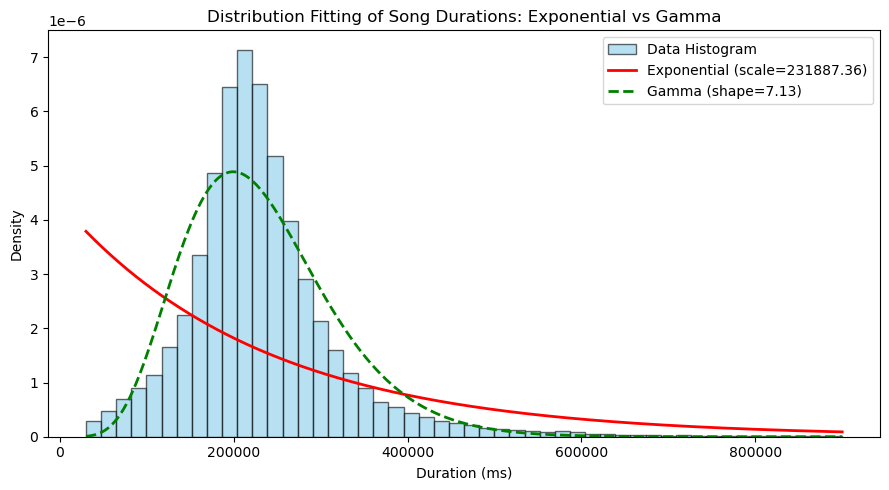

Exponential: KS=0.3542, p=0.0000
Gamma: KS=0.0670, p=0.0000


In [9]:
from scipy.stats import expon, gamma

x = df["duration_ms"].dropna()

# Fit Exponential
exp_loc, exp_scale = expon.fit(x, floc=0)
x_vals = np.linspace(x.min(), x.max(), 1000)
pdf_exp = expon.pdf(x_vals, exp_loc, exp_scale)

# Fit Gamma
gamma_shape, gamma_loc, gamma_scale = gamma.fit(x, floc=0)
pdf_gamma = gamma.pdf(x_vals, gamma_shape, gamma_loc, gamma_scale)

plt.figure(figsize=(9,5))
plt.hist(x, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label="Data Histogram")
plt.plot(x_vals, pdf_exp, 'r-', lw=2, label=f"Exponential (scale={exp_scale:.2f})")
plt.plot(x_vals, pdf_gamma, 'g--', lw=2, label=f"Gamma (shape={gamma_shape:.2f})")
plt.title("Distribution Fitting of Song Durations: Exponential vs Gamma")
plt.xlabel("Duration (ms)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# KS tests
for name, dist, args in [
    ("Exponential", expon, (exp_loc, exp_scale)),
    ("Gamma", gamma, (gamma_shape, gamma_loc, gamma_scale))
]:
    ks_stat, ks_p = kstest(x, dist.name, args=args)
    print(f"{name}: KS={ks_stat:.4f}, p={ks_p:.4f}")


### **Task 2(b): Histogram and Fitted Theoretical Distribution**

The numerical feature **`duration_ms`** was selected for distribution fitting.  
Based on its positive, right-skewed nature and heavy tail, We intially tested log-normal but found that it is not the bestest fit, so we also explored several theoretical distributions- **Log-Normal**, **Exponential**, and **Gamma** - using maximum-likelihood estimation.

#### **Histogram and Curve Overlay**
The histogram of song durations shows that most songs range between **150 000 ms and 300 000 ms** (≈ 2.5 - 5 minutes), with a long right tail extending toward higher durations.  
Overlaying the fitted curves revealed the following:

- **Log-Normal** captured the general skew but slightly over-estimated the tail.  
- **Exponential** decayed too rapidly, failing to represent the main peak.  
- **Gamma** provided the closest overall visual fit, following both the main body and tail of the data.

#### **Goodness-of-Fit Comparison**

| Distribution | KS Statistic | p-value | Interpretation |
|---------------|--------------|---------|----------------|
| Log-Normal | 0.0868 | 0.0000 | Moderate fit |
| Exponential | 0.3542 | 0.0000 | Poor fit |
| **Gamma** | **0.0670** | **0.0000** | *Best (lowest KS), visually closest* |

Although all tests yield **p < 0.05**, indicating none of the models perfectly describe the data, the **Gamma distribution** provides the **best approximation** among the tested options.

#### **Conclusion**
The **Gamma distribution** is the most suitable theoretical model for the `duration_ms` feature.  
It effectively captures the shape of the empirical distribution - a high concentration of average-length songs and a long right tail for extended tracks - even if minor deviations exist statistically.  
And also this aligns with real-world patterns where most songs have a standard duration but a few are significantly longer.


# Task 3

# --- Task 3(a): Randomly sample 100 observations from duration_ms ---

In [13]:
import numpy as np

# --- Task 3(a): Randomly sample 100 observations from duration_ms ---
np.random.seed(42)  # for reproducibility
feature = df["duration_ms"].dropna()

# Population parameters
pop_mean = feature.mean()
pop_var  = feature.var(ddof=1)

# Draw 100 random samples (without replacement)
sample1 = feature.sample(n=100, random_state=42)
sample1_mean = sample1.mean()
sample1_var  = sample1.var(ddof=1)

print("=== Task 3(a): Single Sample vs Population ===")
print(f"Population Mean     : {pop_mean:.2f}")
print(f"Population Variance : {pop_var:.2f}")
print(f"Sample Mean         : {sample1_mean:.2f}")
print(f"Sample Variance     : {sample1_var:.2f}")
print(f"Difference (Mean)   : {sample1_mean - pop_mean:.2f}")
print(f"Difference (Var)    : {sample1_var - pop_var:.2f}")



=== Task 3(a): Single Sample vs Population ===
Population Mean     : 231887.36
Population Variance : 8092881262.34
Sample Mean         : 235149.47
Sample Variance     : 5434722079.04
Difference (Mean)   : 3262.11
Difference (Var)    : -2658159183.30


# --- Task 3(b): Repeat sampling three times ---


=== Sample 1 ===
Mean     : 225917.79
Variance : 5266043708.17

=== Sample 2 ===
Mean     : 232729.61
Variance : 10092142234.46

=== Sample 3 ===
Mean     : 242555.43
Variance : 6743489734.41


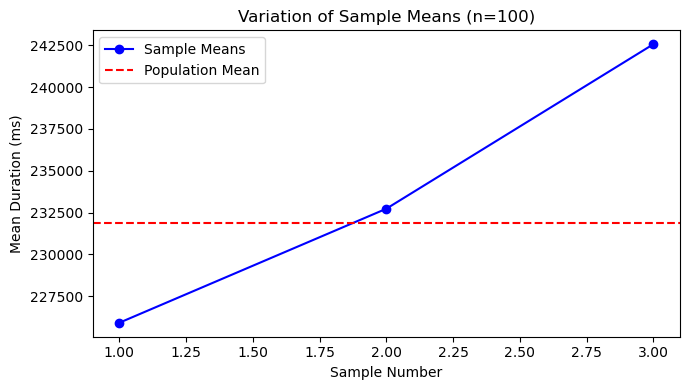

In [15]:
# --- Task 3(b): Repeat sampling three times ---
np.random.seed(None)  
sample_means = []
sample_vars = []

for i in range(1, 4):
    s = feature.sample(n=100, random_state=i)
    sample_means.append(s.mean())
    sample_vars.append(s.var(ddof=1))
    print(f"\n=== Sample {i} ===")
    print(f"Mean     : {sample_means[-1]:.2f}")
    print(f"Variance : {sample_vars[-1]:.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(range(1,4), sample_means, 'bo-', label="Sample Means")
plt.axhline(pop_mean, color='red', linestyle='--', label="Population Mean")
plt.title("Variation of Sample Means (n=100)")
plt.xlabel("Sample Number")
plt.ylabel("Mean Duration (ms)")
plt.legend()
plt.tight_layout()
plt.show()


## Task 3 Findings — Point Estimates

### 3(a) Single-sample point estimates (n = 100)

**Feature:** `duration_ms`  
**Population (full dataset, N = 231,949):**  
- Mean = **231,887.36 ms** (approximately **3.86 min**)  
- Variance = **8.0929 × 10⁹ ms²** (SD approximately **89,960 ms**)

**Sample A (100 songs, random)**  
- Mean = **235,149.47 ms** (approximately **3.92 min**)  
- Variance = **5.4347 × 10⁹ ms²**  
- Mean = **+3,262.11 ms** (approximately **+3.26 s**)  
- Variance = **−2.6582 × 10⁹ ms²** (about **−33%** vs population)

**Interpretation.**  
- The **sample mean** is very close to the population mean (within approximately 3.3 seconds). With SD ≈ 89,960 ms, the **SE of the sample mean** is ≈ 89,960/under root of 100 ≈ **8,996 ms (approximately 9 s)**, so the observed deviation (approximately0.36 SE) is well within expectation.  
- The **sample variance** is notably **lower** than the population variance. Given the **right-skewed, heavy-tailed** distribution of durations, missing a few very long tracks in a small sample tends to **underestimate variance**.

---

### 3(b) Repeated random samples (n = 100 each)

| Sample | Mean (ms) | Mean (min) | Variance (ms²) | Δ Mean vs Pop (ms) | Δ Var vs Pop |
|:--:|--:|--:|--:|--:|--:|
| 1 | **225,917.79** | 3.77 | 5.2660 × 10⁹ | −5,969.57 | −35% |
| 2 | **232,729.61** | 3.88 | 1.0092 × 10¹⁰ | +842.25 | +25% |
| 3 | **242,555.43** | 4.04 | 6.7435 × 10⁹ | +10,668.07 | −17% |

**Observed variability.**  
- **Means:** range from 225,918 to 242,555 ms. The spread across the three means is **16,638 ms (approximately 16.6 s)**, which is about **1.85×** the SE (approximately 9 s). All three sample means lie within a couple of SEs of the population mean exactly what we expect from random sampling.  
- **Variances:** fluctuate widely (**−35%** to **+25%** vs population). Variance is much more **unstable** for small samples, especially under **heavy tails**; the inclusion or exclusion of a few long tracks moves the estimate substantially.

**Discussion.**  
- The **sample mean** behaves as an **unbiased** estimator: different random samples oscillate around the population mean with deviations on the order of the SE.  
- The **sample variance** shows greater volatility because `duration_ms` is **right-skewed with high kurtosis**; with n = 100, a few outliers can dominate the estimate.  
- Increasing the sample size (e.g., n ≥ 500) or using **robust summaries** (median, IQR; or analyzing **log-duration**) would yield more stable dispersion estimates.

**Conclusion.**  
Random sampling of size 100 provides **accurate mean estimates** for `duration_ms`, while **variance estimates are sensitive** to the dataset’s heavy tail. The results match sampling theory (SE ≈ 9 s) and highlight the impact of skewness/kurtosis on small-sample variability.


# Task 4

=== Correlation Matrix (Pearson) ===
               popularity  duration_ms  genre_encoded
popularity          1.000        0.037          0.103
duration_ms         0.037        1.000         -0.001
genre_encoded       0.103       -0.001          1.000


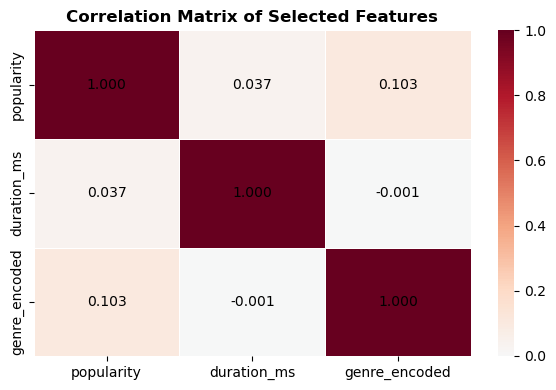

In [18]:
# --- Task 4: Correlation Analysis (Pearson) with Darker Colors ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# If df is not already loaded, uncomment:
# df = pd.read_csv(r"C:\Users\pette\OneDrive\Desktop\Data Science Project(Spotify Song)\newdata.csv")

# Ensure genre is encoded (only if not already present)
if "genre_encoded" not in df.columns:
    le = LabelEncoder()
    df["genre_encoded"] = le.fit_transform(df["genre"].astype(str))

# Select Task-1 features
corr_features = ["popularity", "duration_ms", "genre_encoded"]
corr_df = df[corr_features]

# Compute Pearson correlation matrix
corr_matrix = corr_df.corr(method="pearson", numeric_only=True)
print("=== Correlation Matrix (Pearson) ===")
print(corr_matrix.round(3))

# --- Darker Heatmap Visualization ---
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="RdBu_r",      # darker red–blue palette
    center=0,
    fmt=".3f",
    linewidths=0.6,
    annot_kws={"color": "black", "size": 10}
)
plt.title("Correlation Matrix of Selected Features", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


# Task 5

## **Task 5 — Hypothesis Questions Proposal**

### **Hypothesis 1: Popularity and Song Duration**
**Question:**  
Does a song’s *duration* affect its *popularity*?

**Null Hypothesis (H₀):**  
There is **no significant relationship** between a song’s duration (`duration_ms`) and its popularity score.

**Alternative Hypothesis (H₁):**  
There **is a relationship** between song duration and popularity — longer or shorter songs differ in their popularity levels.

---

### **Hypothesis 2: Popularity and Genre**
**Question:**  
Does the *genre* of a song influence its *popularity*?

**Null Hypothesis (H₀):**  
The **mean popularity** is the same across all genres.

**Alternative Hypothesis (H₁):**  
The **mean popularity** differs across genres.

---

### **Hypothesis 3: Duration and Genre**
**Question:**  
Do songs from different *genres* vary in their *average duration*?

**Null Hypothesis (H₀):**  
The **mean duration (`duration_ms`)** is the same across all genres.

**Alternative Hypothesis (H₁):**  
The **mean duration** differs across genres.

---

### **Summary of Chosen Variables**
The variables chosen are **meaningful, data-driven, and testable**, ensuring consistency and logical continuity across project stages.
